# SCDC
## Results of deconvolution using real bulks, deconvolved with snRNA-seq and scRNA-seq.

We aimed to test the transformations in reference while deconvolving real bulks using SCDC. 
Real bulk data does not have a reliable ground truth, so we used consistency in predictions as a measure of robustness.
The idea is that if a transformation as reference yields similar predicted proportions as the other transformations, it is likely reliable and robust.  

We employed a real-setting experimental design where use all cells observed in 7 datasets of scRNA-seq adipose tissue, and two cell types which are not observed in any scRNA-seq dataset are added from 12 snRNA-seq datasets. We transform these 2 “missing” cell types, fat cells and neutrophils, with each of the transformations, and added the transformed snRNA-seq cell types (and an additional snRNA-seq raw control) to the scRNA-seq observed cell types to create one reference per transform, so all scRNA-seq cells and transformed snRNA-seq. This is similar to what was done in the pseudobulks vs. real bulks experiment above (see Methods for details).

We use each of these references (i.e., with each of the transformations) to deconvolve 434 real bulk samples. We compare the predicted proportions of each used reference with the predicted proportions of the other references (one vector of all predicted proportions vs. one vector of all predicted proportions) and computed the cosine similarity per transform pair. 


In [1]:
method = "SCDC"

## Imports, paths and settings.

In [2]:
import os, re, glob, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from numpy.linalg import norm
from scipy.stats import pearsonr
from sklearn.metrics import root_mean_squared_error
import matplotlib.collections as mcoll
from matplotlib.lines import Line2D
from scipy.stats import ttest_ind, ttest_rel
from scipy.stats import bootstrap
from sklearn.metrics.pairwise import cosine_similarity

sys.path.insert(1, "../../")
sys.path.insert(1, "../")
from src.helpers import compute_metrics, plot_controls, compute_cosine_similarity
from src.helpers import (
    compute_average_expression,
    compute_pearson_similarity,
    open_adipose_datasets_all,
)

In [3]:
# =========================
# Settings
# =========================

dataset = "Real_ADP"

maps = {
    "dendritic cell": "Dendritic Cells",
    "endothelial cell": "Endothelial Cells",
    "smooth muscle cell": "Smooth Muscle Cells",
    "immature NK T cell": "Immature NK T Cells",
    "monocyte": "Monocytes",
    "preadipocyte": "Preadipocytes",
    "T cell": "T Cells",
    "Endothelial cell": "Endothelial Cells",
    "T cell": "T Cells",
    "B cell": "B Cells",
    "pericyte cell": "Pericytes",
    "fat cell": "Fat Cells",
    "neutrophil": "Neutrophils",
    "Macrophage": "Macrophages",
    "macrophage": "Macrophages",
    "Hepatocyte": "Hepatocytes",
    "mast cell": "Mast Cell",
    "endothelial cell of lymphatic vessel": "Endothelial Cells of Lymphatic Vessel",
    "stromal cell of endometrium": "Stromal cells of Endometrium",
    "Epithelial cell": "Epithelial Cells",
}

transform_mapping = {
    "sn_raw_real": "snRNA All (NegCtrl)",
    "rawSN": "snRNA",
    "degSN": "snRNA (-DEG)",
    "degOtherSN": "-DEG Other Datasets",
    "degIntSN": "-DEG Int.",
    "degRandSN": "-Random Genes",
    "pcaSN": "PCA",
    "degpcaSN": "PCA (-DEG)",
    "scvi_LSshift_SN": "scVILS",
    "degScviLSshift_SN": "scVILS (-DEG)",
    "scviSN": "scVIcond",
    "degScviSN": "scVIcond (-DEG)",
    "degIntAllSN": "snRNA All (-DEG Int.)",
}

display_order = [
    "snRNA All (-DEG Int.)",
    "snRNA",
    "snRNA (-DEG)",
    "-DEG Int.",
    "-DEG Other Datasets",
    "-Random Genes",
    "PCA",
    "PCA (-DEG)",
    "scVILS",
    "scVILS (-DEG)",
    "scVIcond",
    "scVIcond (-DEG)",
]

display_palette = {
    "Real": "black",
    "snRNA": "rosybrown",
    "PCA": "#2ca02c",
    "scVILS": "darkorange",
    "scVIcond": "#9467bd",
    "snRNA (-DEG)": "lightcoral",
    "PCA (-DEG)": "#98df8a",
    "scVILS (-DEG)": "sandybrown",
    "scVIcond (-DEG)": "#c5b0d5",
    "-DEG Other Datasets": "goldenrod",
    "-DEG Int.": "tomato",
    "-Random Genes": "chocolate",
    "snRNA All (-DEG Int.)": "m",
}

## Note different setting lower in notebook too.

In [4]:
results_dir = os.path.join("..", "results", dataset)
results_file = results_dir + f"/results_{method}_{dataset}.csv"

## Read in datasets and results

In [5]:
bulks, sc, sn, sn_missing = open_adipose_datasets_all(
    res_name="Real_ADP", base_dir=".."
)

Bulk data shape: (434, 19010)
Combined SN+SC data shape: (63125, 28129)
Number of common genes: 19010
Single-cell data shape: (18967, 19010)
Single-nucleus data shape: (44158, 19010)
Bulk data shape: (434, 19010)
Cell Type counts:
cell_types
preadipocyte                            14700
macrophage                               1039
T cell                                    845
dendritic cell                            812
endothelial cell                          480
immature NK T cell                        420
monocyte                                  314
endothelial cell of lymphatic vessel      145
smooth muscle cell                         70
mast cell                                  64
pericyte cell                              44
B cell                                     31
stromal cell of endometrium                 3
Name: count, dtype: int64
cell_types
preadipocyte                            13166
fat cell                                 9539
endothelial cell               

In [6]:
# ─── Read the long‐format results ─────────────────────────────────────────────
df = pd.read_csv(results_file)
df = df[~df["Transform"].isin(["sc_raw", "sc_raw_real", "sn_raw_real"])]

In [7]:
# Making sure cell type names are OK
df.CellType = df.CellType.replace(maps)
df.CellType.unique()

array(['B Cells', 'Dendritic Cells', 'Endothelial Cells',
       'Endothelial Cells of Lymphatic Vessel', 'Fat Cells',
       'Immature NK T Cells', 'Macrophages', 'Mast Cell', 'Monocytes',
       'Neutrophils', 'Pericytes', 'Preadipocytes', 'Smooth Muscle Cells',
       'T Cells', 'Stromal cells of Endometrium'], dtype=object)

In [8]:
# ─── Pivot to one row per SampleID with a column for each (Transform, CellType) ─
pivot_df = df.pivot(
    index="SampleID", columns=["Transform", "CellType"], values="PredProp"
)

# ─── flatten the MultiIndex columns ────────────────────────────────
pivot_df.columns = [
    f"{transform}__{celltype}" for transform, celltype in pivot_df.columns
]

# ─── Move SampleID back into a column ─────────────────────────────────────────
wide_df = pivot_df.reset_index()

# ─── Check ───────────────────────────────────────────────────────────────────
print("wide_df shape:", wide_df.shape)
wide_df

wide_df shape: (434, 180)


,SampleID,degIntAllSN__B Cells,degIntAllSN__Dendritic Cells,degIntAllSN__Endothelial Cells,degIntAllSN__Endothelial Cells of Lymphatic Vessel,degIntAllSN__Fat Cells,degIntAllSN__Immature NK T Cells,degIntAllSN__Macrophages,degIntAllSN__Mast Cell,degIntAllSN__Monocytes,...,scvi_LSshift_SN__Immature NK T Cells,scvi_LSshift_SN__Macrophages,scvi_LSshift_SN__Mast Cell,scvi_LSshift_SN__Monocytes,scvi_LSshift_SN__Neutrophils,scvi_LSshift_SN__Pericytes,scvi_LSshift_SN__Preadipocytes,scvi_LSshift_SN__Smooth Muscle Cells,scvi_LSshift_SN__Stromal cells of Endometrium,scvi_LSshift_SN__T Cells
0,1,0.016637,0.0,0.032135,0.015482,0.0,0.442332,0.000000,0.0,0.116806,...,0.0,0.430193,0.0,0.0,0.0,0.0,0.126720,0.128695,0.075447,0.195140
1,2,0.000000,0.0,0.080730,0.015902,0.0,0.336932,0.000000,0.0,0.102985,...,0.0,0.482705,0.0,0.0,0.0,0.0,0.131311,0.153440,0.071945,0.101361
2,3,0.000000,0.0,0.105035,0.027964,0.0,0.370623,0.000000,0.0,0.093348,...,0.0,0.361926,0.0,0.0,0.0,0.0,0.184785,0.159083,0.066072,0.113031
3,4,0.000000,0.0,0.065576,0.012906,0.0,0.399835,0.000000,0.0,0.138094,...,0.0,0.572186,0.0,0.0,0.0,0.0,0.162320,0.114967,0.070288,0.041828
4,5,0.000000,0.0,0.107336,0.020595,0.0,0.332005,0.000000,0.0,0.106962,...,0.0,0.425998,0.0,0.0,0.0,0.0,0.243420,0.152184,0.076072,0.042265
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
429,430,0.022852,0.0,0.039208,0.017059,0.0,0.492514,0.000000,0.0,0.123875,...,0.0,0.584338,0.0,0.0,0.0,0.0,0.176686,0.153354,0.070878,0.011725
430,431,0.003096,0.0,0.004976,0.004214,0.0,0.458041,0.000000,0.0,0.162725,...,0.0,0.517446,0.0,0.0,0.0,0.0,0.010957,0.097311,0.068223,0.282515
431,432,0.016855,0.0,0.029627,0.011298,0.0,0.480252,0.000000,0.0,0.108195,...,0.0,0.464101,0.0,0.0,0.0,0.0,0.083249,0.121898,0.073530,0.217128
432,433,0.002494,0.0,0.102945,0.016920,0.0,0.395271,0.000000,0.0,0.113774,...,0.0,0.422189,0.0,0.0,0.0,0.0,0.133907,0.158832,0.071838,0.121840


In [9]:
# 1) Identify transforms and their cell‐type columns
transform2cts = {}
for col in wide_df.columns:
    if "__" in col:
        t, ct = col.split("__", 1)
        transform2cts.setdefault(t, []).append(ct)

# 2) Compute the set of cell‐types common to *all* transforms
common_cts = set(transform2cts[next(iter(transform2cts))])
for cts in transform2cts.values():
    common_cts &= set(cts)

# 3) For each transform, build a flattened vector of only those common cell‐types
vecs = {}
for t, cts in transform2cts.items():
    # only keep the common ones, and in a consistent order
    keep = sorted(common_cts)
    cols = [f"{t}__{ct}" for ct in keep]
    # this will be shape (n_samples, len(common_cts)), ravel() → 1D
    vecs[t] = wide_df[cols].to_numpy().ravel()

# 4) Compute pairwise Pearson correlations
transforms = sorted(vecs)
corr = pd.DataFrame(index=transforms, columns=transforms, dtype=float)
for t1 in transforms:
    for t2 in transforms:

        corr.loc[t1, t2] = cosine_similarity(
            vecs[t1].reshape(1, -1), vecs[t2].reshape(1, -1)
        )[0, 0]
corr

,degIntAllSN,degIntSN,degOtherSN,degRandSN,degSN,degScviLSshift_SN,degScviSN,degpcaSN,pcaSN,rawSN,scviSN,scvi_LSshift_SN
degIntAllSN,1.000000,0.107515,0.114181,0.059311,0.274164,0.379226,0.268821,0.410986,0.050305,0.059495,0.050467,0.043254
degIntSN,0.107515,1.000000,0.930017,0.953242,0.750568,0.002423,0.536262,0.298271,0.943571,0.954482,0.943778,0.707679
degOtherSN,0.114181,0.930017,1.000000,0.873803,0.719990,0.024922,0.527441,0.316581,0.860475,0.873321,0.860727,0.662576
degRandSN,0.059311,0.953242,0.873803,1.000000,0.629224,0.001894,0.394771,0.228968,0.993180,0.995873,0.993309,0.743711
degSN,0.274164,0.750568,0.719990,0.629224,1.000000,0.198687,0.948413,0.666996,0.594075,0.628972,0.594559,0.466274
degScviLSshift_SN,0.379226,0.002423,0.024922,0.001894,0.198687,1.000000,0.199510,0.810322,0.001827,0.001891,0.002231,0.001461
degScviSN,0.268821,0.536262,0.527441,0.394771,0.948413,0.199510,1.000000,0.688152,0.348933,0.391264,0.349529,0.292944
degpcaSN,0.410986,0.298271,0.316581,0.228968,0.666996,0.810322,0.688152,1.000000,0.203718,0.226127,0.204439,0.175923
pcaSN,0.050305,0.943571,0.860475,0.993180,0.594075,0.001827,0.348933,0.203718,1.000000,0.998579,0.999995,0.751593
rawSN,0.059495,0.954482,0.873321,0.995873,0.628972,0.001891,0.391264,0.226127,0.998579,1.000000,0.998609,0.749640


In [10]:
corr.to_csv(
    os.path.join(results_dir, "transform_pairwise_consistency.csv"), index=True
)  ## saving for later use

In [11]:
# 2) Invert the mapping: display_name → transform code
display_to_code = {v: k for k, v in transform_mapping.items()}

# 3) Build ordered list of transform codes
ordered_codes = [display_to_code[name] for name in display_order]

# 4) Reindex correlation matrix
corr_ordered = corr.loc[ordered_codes, ordered_codes]

## Heatmap of cosine similarity

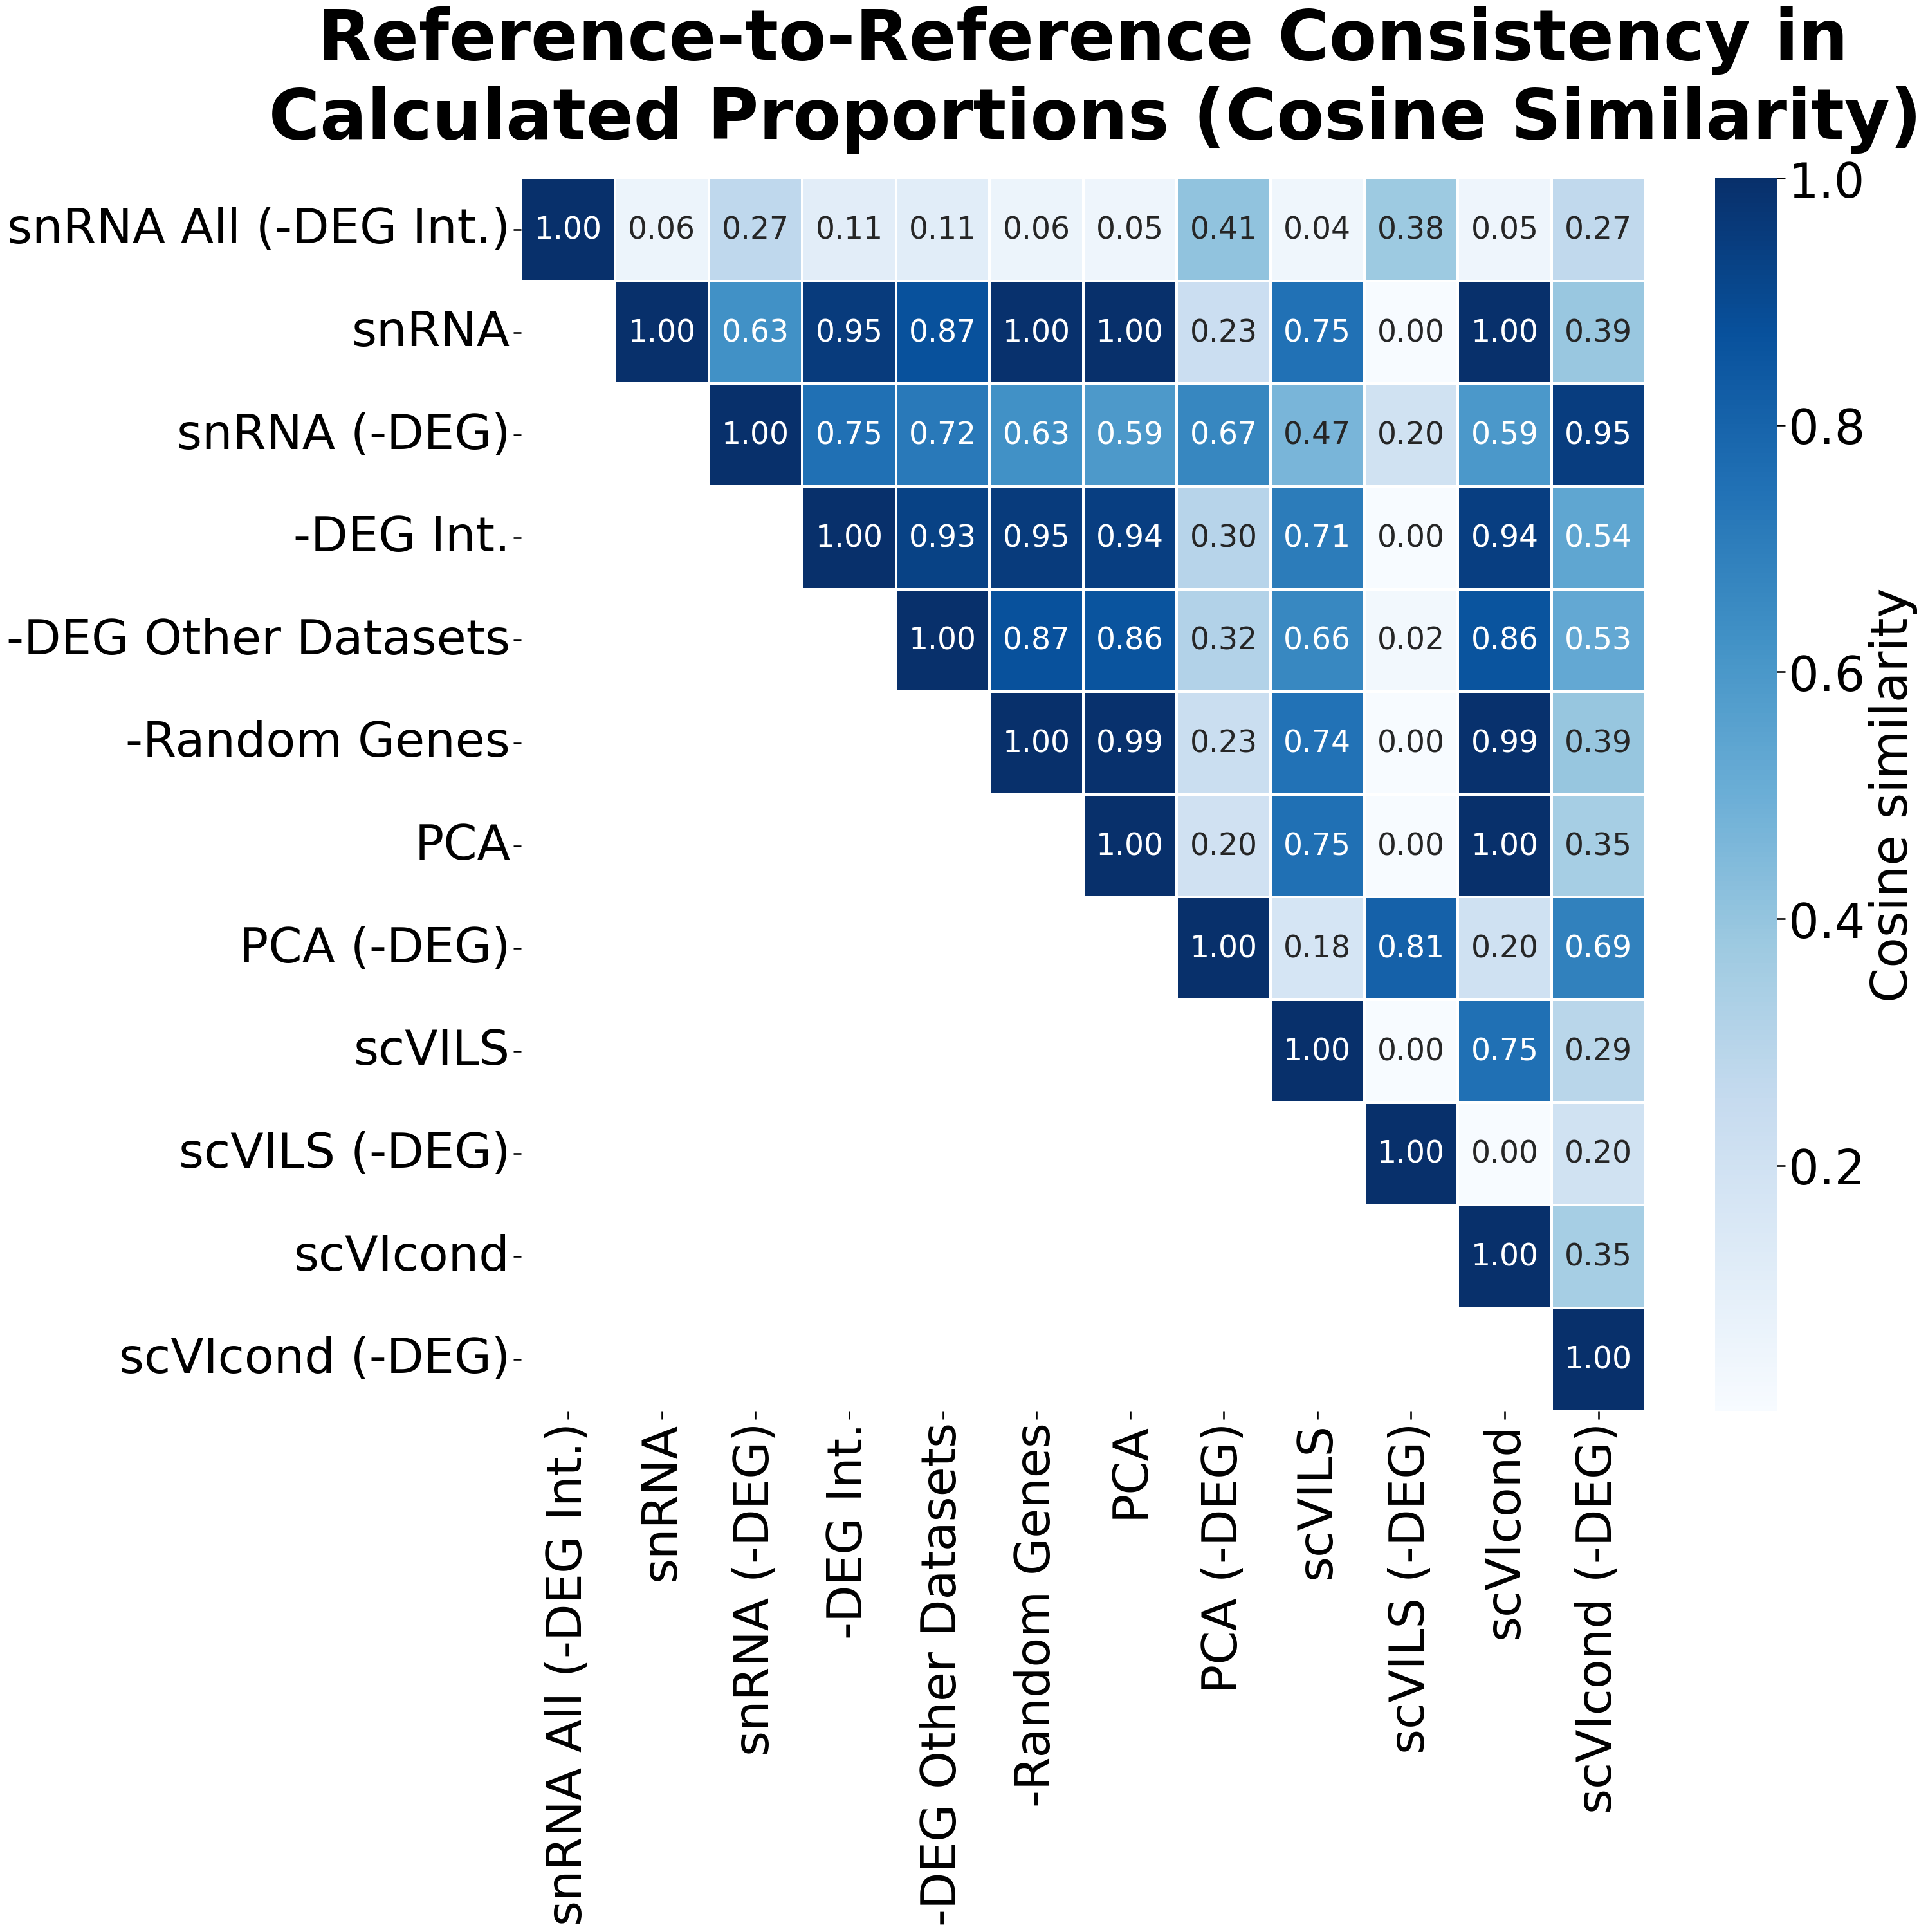

In [12]:
mask = np.tril(np.ones_like(corr_ordered, dtype=bool), k=-1)
sns.set_context("talk", font_scale=4)
# ─── Create the figure + axes ───────────────────────────────────────────
fig, ax = plt.subplots(figsize=(32, 32))
palette = sns.color_palette("Blues", as_cmap=True)

# ─── Plot the heatmap with mask and big fonts ───────────────────────────
sns.heatmap(
    corr_ordered,
    mask=mask,
    cmap=palette,
    center=0.5,
    annot=True,
    fmt=".2f",
    annot_kws={"size": 34},  # annotation font size
    linewidths=1.5,
    cbar_kws={"label": "Cosine similarity"},  # colorbar label
    xticklabels=display_order,
    yticklabels=display_order,
    ax=ax,
)

# ─── Ticks ───────────────────────────────────────────────────────────────
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center", fontsize=54)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=54)

# ─── Colorbar ticks & label size ────────────────────────────────────────
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=54)
cbar.set_label("Cosine similarity", fontsize=56)

# ─── Title ───────────────────────────────────────────────────────────────
ax.set_title(
    "Reference‑to‑Reference Consistency in\n Calculated Proportions (Cosine Similarity)",
    fontsize=78,
    pad=45,
    fontweight="bold",
)

plt.tight_layout()
plt.show()

In [13]:
# Exclude self‐similarity by setting the diagonal to NaN
sim_noself = corr.copy()
np.fill_diagonal(sim_noself.values, np.nan)

# Compute mean and standard deviation of similarity for each transform
stats = pd.DataFrame(
    {"mean_sim": sim_noself.mean(axis=1), "std_sim": sim_noself.std(axis=1)}
)

# Sort by descending mean similarity (most “in agreement” first)
stats = stats.sort_values("mean_sim", ascending=False)
print(stats)

                   mean_sim   std_sim
degIntSN           0.647982  0.360452
rawSN              0.625296  0.390417
degRandSN          0.624299  0.388667
degOtherSN         0.614912  0.325976
scviSN             0.613578  0.394877
pcaSN              0.613296  0.395027
degSN              0.588357  0.211735
scvi_LSshift_SN    0.486070  0.303644
degScviSN          0.449640  0.215781
degpcaSN           0.384589  0.228903
degIntAllSN        0.165248  0.140848
degScviLSshift_SN  0.147672  0.253077


## Plot of mean with 95% CI (unordered and ordered by mean)

In [14]:
# build a long DataFrame of all pairwise sims (excluding self)
dist_df = (
    sim_noself.stack()
    .reset_index()
    .rename(columns={"level_0": "Ref", "level_1": "OtherRef", 0: "Similarity"})
)
# map to display names
dist_df["RefName"] = dist_df["Ref"].map(transform_mapping)

/projects/aivich@xsede.org/code-server/tmp/ipykernel_3648578/2903457505.py:7: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  ax = sns.pointplot(
/projects/aivich@xsede.org/code-server/tmp/ipykernel_3648578/2903457505.py:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=54)


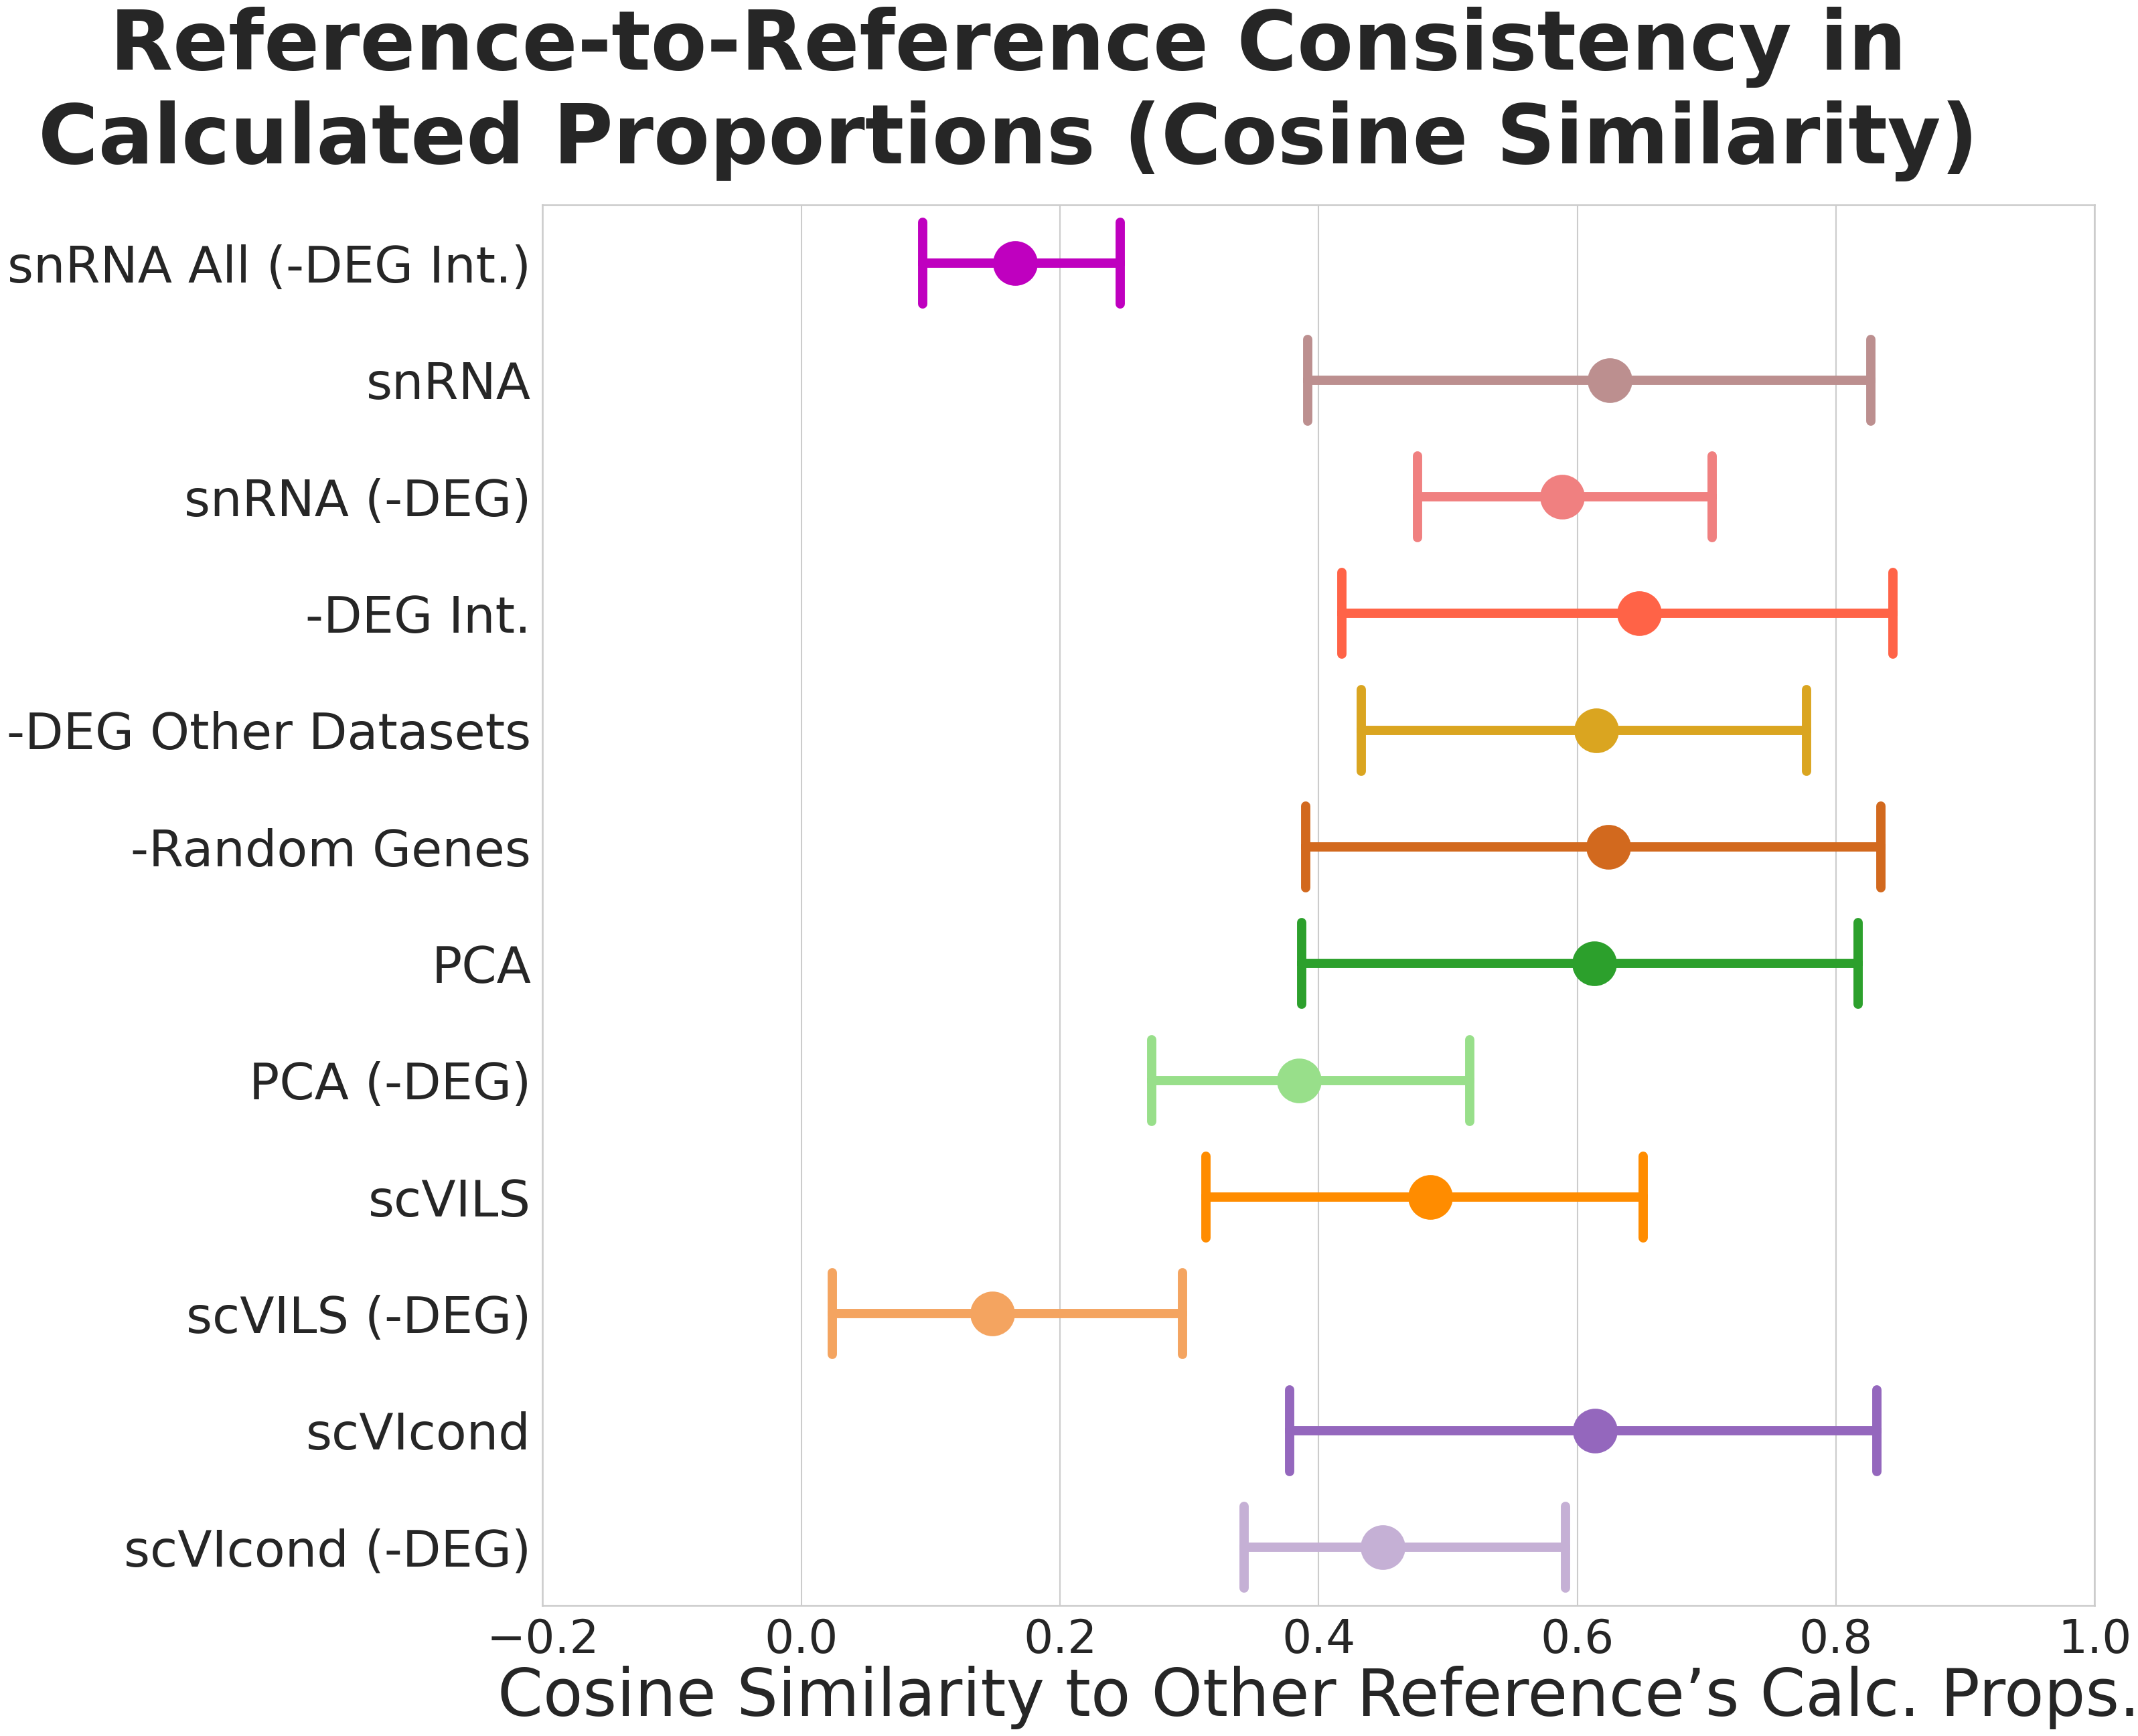

In [15]:
# ─── Plot settings ───────────────────────────────────────────────────────────
sns.set_style("whitegrid")
sns.set_context("talk", font_scale=4.2)

# ─── Draw the pointplot ──────────────────────────────────────────────────────
plt.figure(figsize=(34, 28))
ax = sns.pointplot(
    y="RefName",
    x="Similarity",
    data=dist_df,
    order=display_order,
    palette=display_palette,
    estimator=np.mean,
    ci=95,  # bootstrap 95% CI of the mean
    n_boot=1000,  # match your 1,000 resamples
    join=False,
    capsize=0.7,  # length of the CI “caps”
    errwidth=10,  # thickness of the CI bars
    markers="o",
    markersize=45,
)

# ─── Formatting ──────────────────────────────────────────────────────────────
ax.set_xlabel("Cosine Similarity to Other Reference’s Calc. Props.", fontsize=70)
ax.set_ylabel("")  # no y‐axis label, names on ticks
ax.set_xticks(ax.get_xticks())
ax.set_xticklabels(ax.get_xticklabels(), fontsize=50)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=54)
ax.set_title(
    "Reference-to-Reference Consistency in\nCalculated Proportions (Cosine Similarity)",
    fontsize=88,
    fontweight="bold",
    pad=45,
    x=0.3,
)

plt.tight_layout()
plt.show()

/projects/aivich@xsede.org/code-server/tmp/ipykernel_3648578/476658350.py:13: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  ax = sns.pointplot(
/projects/aivich@xsede.org/code-server/tmp/ipykernel_3648578/476658350.py:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), fontsize=50)
/projects/aivich@xsede.org/code-server/tmp/ipykernel_3648578/476658350.py:36: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=54)


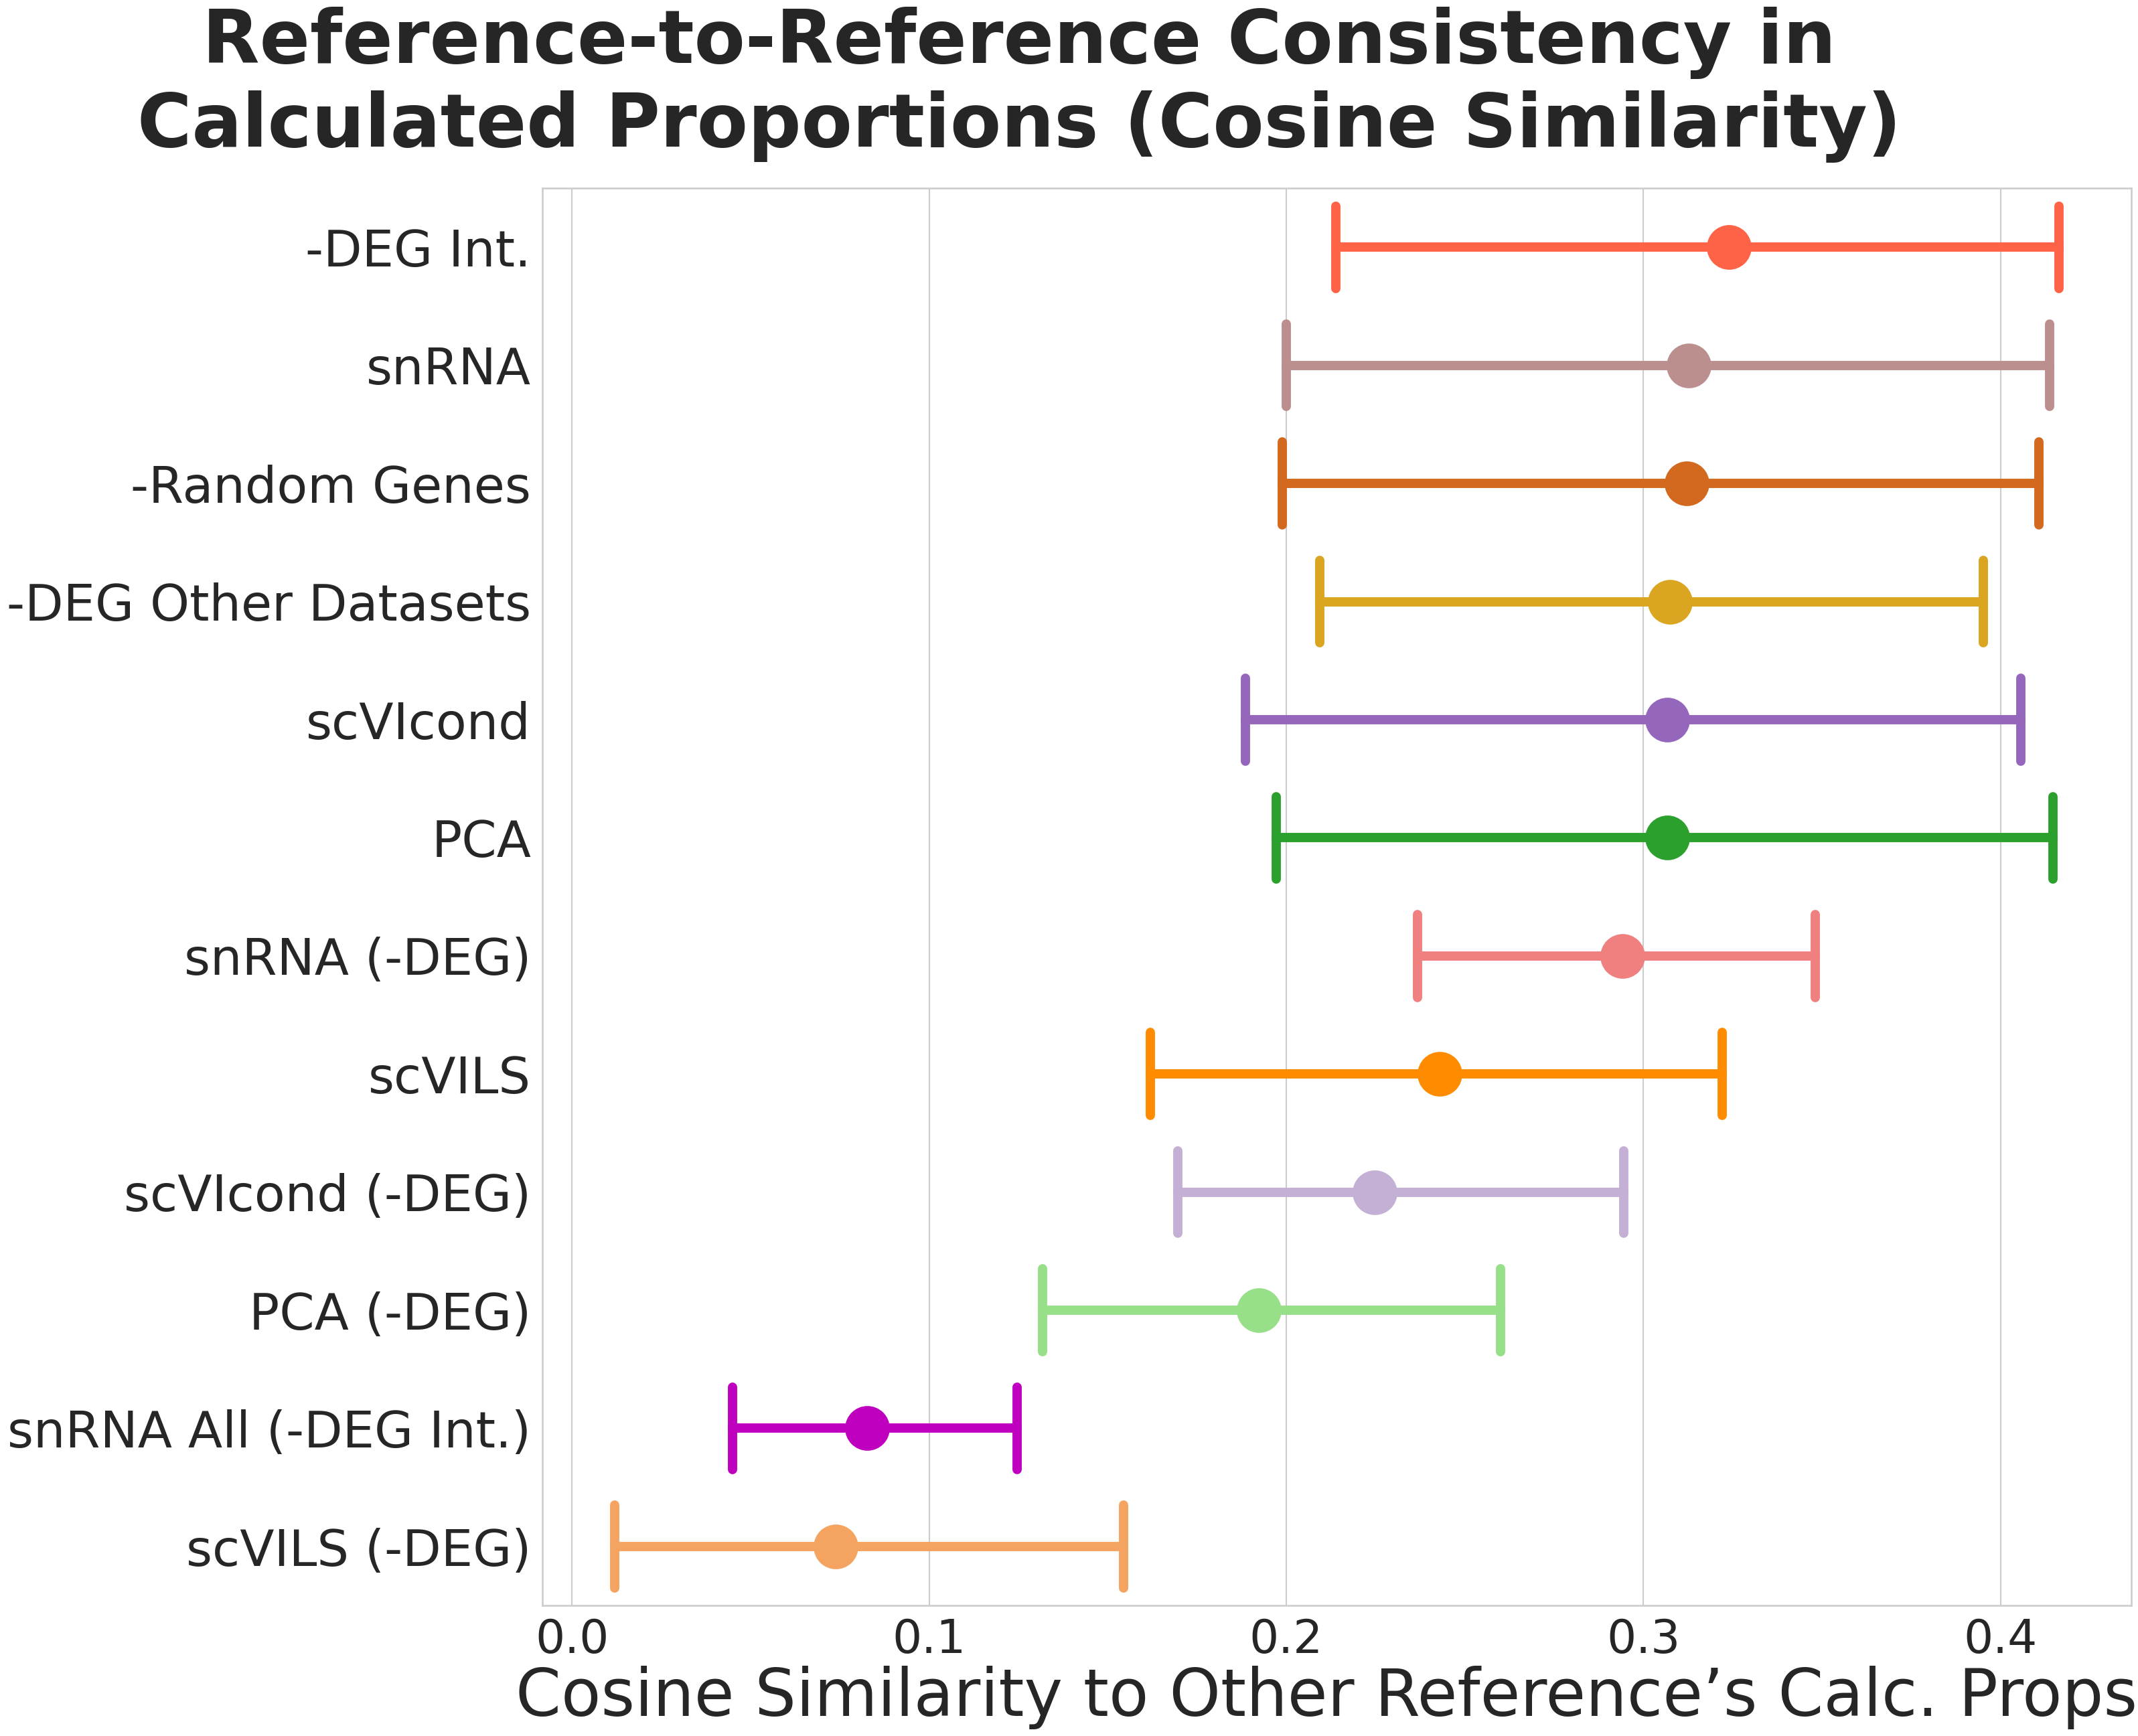

In [16]:
#  Compute a new order by descending mean similarity
order_by_mean = (
    dist_df.groupby("RefName")["Similarity"]
    .mean()
    .sort_values(ascending=False)
    .index.tolist()
)

sns.set_style("whitegrid")
sns.set_context("talk", font_scale=4.2)

plt.figure(figsize=(34, 28))
ax = sns.pointplot(
    y="RefName",
    x="Similarity",
    data=dist_df,
    order=order_by_mean,  # <- use the new order
    palette=display_palette,
    estimator=np.mean,
    ci=95,  # bootstrap 95% CI of the mean
    n_boot=1000,  # 1,000 resamples
    join=False,
    capsize=0.7,
    errwidth=10,
    markers="o",
    markersize=45,
)

# re-enable vertical grid lines if you need them
ax.xaxis.grid(True)

# formatting
ax.set_xlabel("Cosine Similarity to Other Reference’s Calc. Props.", fontsize=70)
ax.set_ylabel("")  # tick labels show the names
ax.set_xticklabels(ax.get_xticklabels(), fontsize=50)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=54)
ax.set_title(
    "Reference-to-Reference Consistency in\nCalculated Proportions (Cosine Similarity)",
    fontsize=80,
    fontweight="bold",
    pad=45,
    x=0.3,
)

plt.tight_layout()
plt.show()

## Comparison of caluclated proportions (no ground truth, just for observation)

In [17]:
df["Reference"] = df["Transform"].map(transform_mapping)

In [18]:
# ─── Plot settings ───────────────────────────────────────────────────────────
sns.set_style("whitegrid")
sns.set_context("talk", font_scale=4.2)

# ─── Faceted boxplots ────────────────────────────────────────────────────────
col_wrap = 4
g = sns.FacetGrid(
    df,
    col="CellType",
    col_wrap=col_wrap,
    sharey=False,
    sharex=True,
    height=18,
    aspect=1.4,
)
g.map_dataframe(
    sns.boxplot,
    x="Reference",
    y="PredProp",
    order=display_order,
    palette=display_palette,
    fliersize=8,
    linewidth=3.5,
)

# ─── Bold facet titles ───────────────────────────────────────────────────────
g.set_titles("{col_name}", fontweight="bold")

# ─── Remove x‑axis labels, and only label y‑axis on leftmost column ─────────
for idx, ax in enumerate(g.axes.flatten()):
    # remove all x ticks
    ax.tick_params(axis="x", labelbottom=False, bottom=False)
    ax.set_xlabel("")

    # only set y‑axis label on the leftmost plots
    if idx % col_wrap == 0:
        ax.set_ylabel("Pred. Prop.", fontsize=79)
    else:
        ax.set_ylabel("")

# ─── Custom legend outside the plot area ────────────────────────────────────
handles = [
    Line2D([0], [0], color=display_palette[name], lw=30) for name in display_order
]
g.fig.legend(
    handles,
    display_order,
    title="Reference",
    bbox_to_anchor=(0.90, -0.04),
    loc="lower right",
    fontsize=72,
    title_fontsize=80,
    frameon=True,
)
# ─── Title and layout ───────────────────────────────────────────────────────
g.fig.subplots_adjust(top=0.92, right=0.95, wspace=0.15, hspace=0.25)

g.fig.suptitle(
    "Distribution of Pred. Proportions by Cell Type and Reference",
    fontsize=126,
    fontweight="bold",
)
plt.show()

In [19]:
out_dir = os.path.join("..", "results", dataset)
# 1) Save full pairwise cosine‐similarity matrix
corr_ordered.to_csv(os.path.join(out_dir, f"transform_{method}_consistency_cosine.csv"))

# 2) Save per‐transform summary (mean ± std)
stats.to_csv(os.path.join(out_dir, f"transform_{method}_consistency_summary.csv"))

print("Wrote:")
print(" ", os.path.join(out_dir, f"transform_{method}_consistency_cosine.csv"))
print(" ", os.path.join(out_dir, f"transform_{method}_consistency_summary.csv"))

Wrote:
  ../results/Real_ADP/transform_SCDC_consistency_cosine.csv
  ../results/Real_ADP/transform_SCDC_consistency_summary.csv
